In [49]:
from imutils import paths
import math
import numpy as np
import os
from keras.layers import LSTM,Dense
from keras.models import Sequential
from sklearn.svm import SVR
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

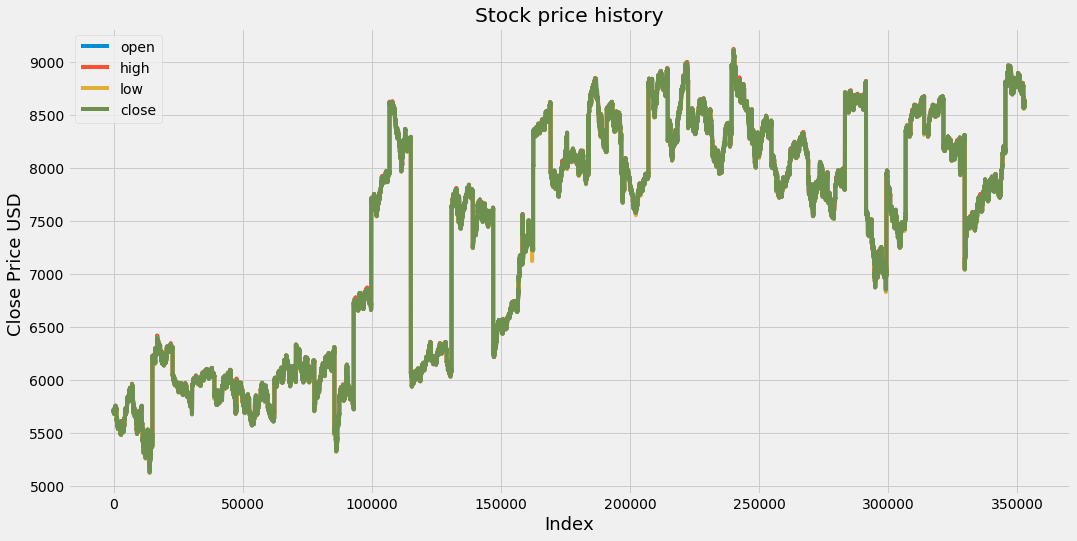

In [52]:
stock_data=pd.read_csv(r'nifty50.csv')
plt.figure(figsize=(16,8))
plt.plot(stock_data["open"])
plt.plot(stock_data["high"])
plt.plot(stock_data["low"])
plt.plot(stock_data["close"])
plt.title('Stock price history')
plt.legend(['open','high','low','close'], loc='upper left')
plt.xlabel('Index',fontsize=18)
plt.ylabel('Close Price USD ',fontsize=18)
plt.show()

In [53]:
stock_data.head()

,index,date,time,open,high,low,close
0,NIFTY,20130401,09:16,5701.15,5704.65,5694.30,5697.00
1,NIFTY,20130401,09:17,5697.05,5698.35,5695.65,5697.50
2,NIFTY,20130401,09:18,5697.90,5697.90,5690.60,5692.15
3,NIFTY,20130401,09:19,5691.65,5694.70,5691.65,5693.90
4,NIFTY,20130401,09:20,5694.40,5695.05,5693.35,5694.55


In [54]:
stock_data['date']=stock_data['date'].apply(lambda x:str(x))

In [55]:
stock_data['date']=stock_data['date'].apply(lambda x:x[:4]+'-'+x[4:6]+'-'+x[6:])

In [56]:
stock_data['date']

0         2013-04-01
1         2013-04-01
2         2013-04-01
3         2013-04-01
4         2013-04-01
             ...    
352915    2016-09-30
352916    2016-09-30
352917    2016-09-30
352918    2016-09-30
352919    2016-09-30
Name: date, Length: 352920, dtype: object

In [57]:
stock_data.head()

,index,date,time,open,high,low,close
0,NIFTY,2013-04-01,09:16,5701.15,5704.65,5694.30,5697.00
1,NIFTY,2013-04-01,09:17,5697.05,5698.35,5695.65,5697.50
2,NIFTY,2013-04-01,09:18,5697.90,5697.90,5690.60,5692.15
3,NIFTY,2013-04-01,09:19,5691.65,5694.70,5691.65,5693.90
4,NIFTY,2013-04-01,09:20,5694.40,5695.05,5693.35,5694.55


In [58]:
def filter_month(month):
    i=0
    stock_filtered=None
    for rows in stock_data.values:
        if(i!=0):
            #print(rows.reshape(1,rows.shape[0]).shape)
            y=rows[1].split('-')[0]
            m=rows[1].split('-')[1]
            d=rows[1].split('-')[2]
            #print(y)
            if(y=='2013' and m==month):
                if(stock_filtered is None):
                    stock_filtered=rows
                else:
                    stock_filtered=np.vstack([stock_filtered,rows])
        i+=1
    return stock_filtered

In [59]:
stock_month={}
for i in range(1,13):
    if(i<=9):
        stock_month[i]=filter_month('0'+str(i))
    else:
        stock_month[i]=filter_month(str(i))

In [60]:
stock_month[2].shape

(7500, 7)

In [87]:
#MAI calculation
def Tech_indicator(stock_month):
    stock_new=None
    f=0
    c=0
    s_open=0
    s_high=0
    s_close=0
    s_low=0
    for rows in stock_month:
        if(f==0):
            d=rows[1].split('-')[-1]
            f=1
        if(rows[1].split('-')[-1]==d):
            s_open+=rows[3]
            s_high+=rows[4]
            s_low+=rows[5]
            s_close+=rows[-1]
            p=rows[1]
            c+=1
        else:
            s_open_avg=round(s_open/c,3)
            s_high_avg=round(s_high/c,3)
            s_close_avg=round(s_close/c,3)
            s_low_avg=round(s_low/c,3)
            if stock_new is None:
                stock_new=[p,s_open_avg,s_high_avg,s_low_avg,s_close_avg]
            else:
                stock_new=np.vstack([stock_new,[p,s_open_avg,s_high_avg,s_low_avg,s_close_avg]])
            f=0
            c=0
            s_open=0
            s_high=0
            s_close=0
            s_low=0
    return stock_new
        

In [88]:
def RSI_indicator(stock_month):
    stock_new=None
    rsi=[]
    #print(stock_month.shape)
    for i in range(0,stock_month.shape[0],14):# 14 period RSI
       if i+14>(stock_month.shape[0]-1):
         break
       avg_high=round(sum(stock_month[i:i+14][:,4])/14,3)
       avg_low=round(sum(stock_month[i:i+14][:,5])/14,3)
       close_new=stock_month[14+i,-1]
       open_new=stock_month[14+i,3]
       p=stock_month[14+i,1]
       s=avg_high/avg_low
       rsi=100-(100/(s+1))
       if stock_new is None:
            stock_new=[p,open_new,rsi,close_new]
       else:
            stock_new=np.vstack([stock_new,[p,open_new,rsi,close_new]])
       #print(avg_high,avg_low,rsi,close_new)
       #print(i)
    return stock_new

In [89]:
def Stochastic_indicator(stock_month):
    stock_new=None
    rsi=[]
    #print(stock_month.shape)
    for i in range(0,stock_month.shape[0],14):# 14 period RSI
       if i+14>(stock_month.shape[0]-1):
         break
       recent_open=stock_month[14+i,3]
       max_high=round(max(stock_month[i:i+14][:,4]),3)
       #recent_low=stock_month[14+i,5]
       min_low=round(min(stock_month[i:i+14][:,5]),3)
       recent_close=stock_month[14+i,-1]
       p=stock_month[14+i,1]
       K=((recent_close-min_low)/(max_high-min_low))*100
       #print(K)
       if stock_new is None:
            stock_new=[p,recent_open,K,recent_close]
       else:
            stock_new=np.vstack([stock_new,[p,recent_open,K,recent_close]])
    return stock_new

In [90]:
def Channel_comodity_index(stock_month):
    stock_new=None
    rsi=[]
    #print(stock_month.shape)
    for i in range(0,stock_month.shape[0],14):# 14 period RSI
       if i+20>(stock_month.shape[0]-1):
         break
       sma_tp=round(sum((np.sum(stock_month[i:i+20,3:],axis=1)))/20,3)
       high=stock_month[i+20,4]
       low=stock_month[i+20,5]
       close=stock_month[i+20,-1]
       p=stock_month[i+20,1]
       tp=round((high+low+close)/3,3)
       tp_i=np.sum(stock_month[i:i+20,3:],axis=1)
       mean_dev=sum(abs(tp_i-sma_tp))/20
       #print(mean_dev)
       #mean_dev=sum(np.sum(stock_month[i:i+20,3:],axis=1)-np.mean(np.sum(stock_month[i:i+20,3:],axis=1)))/20
       #print(tp)
       cci=(tp-sma_tp)/(0.015*mean_dev)
       #print(cci)
       if stock_new is None:
            stock_new=[p,high,low,cci,close]
       else:
            stock_new=np.vstack([stock_new,[p,high,low,cci,close]])
       #print('-----')
    return stock_new

In [91]:
#Channel_comodity_index(stock_month[2])

In [92]:
stock_MAI={}
for i in range(1,13):
    stock_MAI[i]=Tech_indicator(stock_month[i])
    stock_MAI[i]=pd.DataFrame(stock_MAI[i],columns=['date','open','high','low','close'])

In [93]:
for i in range(1,13):
    print(stock_MAI[i].head())
    print("-------------------------")

         date      open      high       low     close
0  2013-01-01  5950.678  5951.491  5949.987   5950.69
1  2013-01-02  5995.683  5996.423  5994.944  5995.672
2  2013-01-03  6003.064  6003.869  6002.386  6003.127
3  2013-01-04  5994.876  5995.617  5994.189   5994.91
4  2013-01-07   6011.58  6012.193  6010.783  6011.475
-------------------------
         date      open      high       low     close
0  2013-02-01  6024.894  6025.906  6023.723  6024.791
1  2013-02-04  6014.584  6015.614  6013.445  6014.558
2  2013-02-05  5959.678  5960.533  5958.706  5959.692
3  2013-02-06  5971.479  5972.353  5970.522  5971.484
4  2013-02-07  5948.599  5949.771  5947.782   5948.84
-------------------------
         date      open      high       low     close
0  2013-03-01  5713.897   5715.72  5712.182  5713.982
1  2013-03-04  5685.865  5687.244  5684.264  5685.982
2  2013-03-05  5754.781  5755.952  5753.738  5754.942
3  2013-03-06  5814.891  5815.871  5813.786  5814.933
4  2013-03-07  5818.471  5819.

In [94]:
Stock_MAI=None
for i in range(1,13):
    if Stock_MAI is None:
        Stock_MAI=stock_MAI[i]
    else:
        Stock_MAI=pd.concat([Stock_MAI,stock_MAI[i]]) 

In [95]:
Stock_MAI.head(10)

,date,open,high,low,close
0,2013-01-01,5950.678,5951.491,5949.987,5950.69
1,2013-01-02,5995.683,5996.423,5994.944,5995.672
2,2013-01-03,6003.064,6003.869,6002.386,6003.127
3,2013-01-04,5994.876,5995.617,5994.189,5994.91
4,2013-01-07,6011.58,6012.193,6010.783,6011.475
5,2013-01-08,5979.402,5980.284,5978.617,5979.467
6,2013-01-09,6001.328,6002.066,6000.466,6001.249
7,2013-01-10,5973.296,5974.249,5972.279,5973.191
8,2013-01-11,5973.169,5974.181,5972.017,5973.01
9,2013-01-14,5994.487,5995.522,5993.539,5994.583


In [96]:
Stock_MAI.shape

(237, 5)

In [97]:
stock_RSI={}
for i in range(1,13):
    stock_RSI[i]=RSI_indicator(stock_month[i])
    stock_RSI[i]=pd.DataFrame(stock_RSI[i],columns=['date','open','RSI','close'])

In [98]:
for i in range(1,13):
    print(stock_RSI[i].head())
    print("-------------------------")

         date     open                 RSI    close
0  2013-01-01   5946.2   50.01119351294685  5945.55
1  2013-01-01   5942.4   50.00821120307454   5943.6
2  2013-01-01   5949.8   50.00644416840592   5949.9
3  2013-01-01  5949.45    50.0065883714907   5949.5
4  2013-01-01   5949.9  50.005130449127336   5949.4
-------------------------
         date     open                 RSI    close
0  2013-02-01   6044.0   50.01153846694856  6041.25
1  2013-02-01   6047.8  50.008841794380785   6046.5
2  2013-02-01   6045.5   50.00920001240451  6044.55
3  2013-02-01  6042.75  50.007343217345245   6042.7
4  2013-02-01  6034.65   50.00889844825962   6037.5
-------------------------
         date     open                 RSI    close
0  2013-03-01  5692.95  50.030834959516625   5698.0
1  2013-03-01  5700.05  50.027499200574006  5702.05
2  2013-03-01  5704.25   50.01891602826898   5704.8
3  2013-03-01  5724.05   50.01659169855163  5724.65
4  2013-03-01   5717.0  50.012044576729465   5718.8
------------

In [99]:
Stock_RSI=None
for i in range(1,13):
    if Stock_RSI is None:
        Stock_RSI=stock_RSI[i]
    else:
        Stock_RSI=pd.concat([Stock_RSI,stock_RSI[i]]) 

In [100]:
Stock_RSI.head(10)

,date,open,RSI,close
0,2013-01-01,5946.2,50.01119351294685,5945.55
1,2013-01-01,5942.4,50.00821120307454,5943.6
2,2013-01-01,5949.8,50.00644416840592,5949.9
3,2013-01-01,5949.45,50.0065883714907,5949.5
4,2013-01-01,5949.9,50.005130449127336,5949.4
5,2013-01-01,5945.35,50.005014263119776,5944.95
6,2013-01-01,5946.35,50.00507512402938,5947.15
7,2013-01-01,5947.2,50.00517908014828,5946.7
8,2013-01-01,5947.25,50.00418700897231,5947.65
9,2013-01-01,5952.55,50.004365550253866,5951.45


In [101]:
Stock_RSI.shape

(6634, 4)

In [102]:
stock_OSC={}
for i in range(1,13):
    stock_OSC[i]=Stochastic_indicator(stock_month[i])
    stock_OSC[i]=pd.DataFrame(stock_OSC[i],columns=['date','open','OSC','close'])

In [103]:
for i in range(1,13):
    print(stock_OSC[i].head())
    print("-------------------------")

         date     open                 OSC    close
0  2013-01-01   5946.2   81.81818181818117  5945.55
1  2013-01-01   5942.4  18.518518518519766   5943.6
2  2013-01-01   5949.8   91.25683060109057   5949.9
3  2013-01-01  5949.45   41.05263157894354   5949.5
4  2013-01-01   5949.9   35.52631578945763   5949.4
-------------------------
         date     open                 OSC    close
0  2013-02-01   6044.0   55.21885521885602  6041.25
1  2013-02-01   6047.8  44.871794871795565   6046.5
2  2013-02-01   6045.5  28.930817610065844  6044.55
3  2013-02-01  6042.75   55.21472392637668   6042.7
4  2013-02-01  6034.65   41.37931034482711   6037.5
-------------------------
         date     open                 OSC    close
0  2013-03-01  5692.95  34.615384615383824   5698.0
1  2013-03-01  5700.05   94.86081370449764  5702.05
2  2013-03-01  5704.25   79.74137931034858   5704.8
3  2013-03-01  5724.05     85.446985446985  5724.65
4  2013-03-01   5717.0  20.851063829785684   5718.8
------------

In [104]:
Stock_OSC=None
for i in range(1,13):
    if Stock_OSC is None:
        Stock_OSC=stock_OSC[i]
    else:
        Stock_OSC=pd.concat([Stock_OSC,stock_OSC[i]]) 

In [105]:
Stock_OSC.head(10)

,date,open,OSC,close
0,2013-01-01,5946.2,81.81818181818117,5945.55
1,2013-01-01,5942.4,18.518518518519766,5943.6
2,2013-01-01,5949.8,91.25683060109057,5949.9
3,2013-01-01,5949.45,41.05263157894354,5949.5
4,2013-01-01,5949.9,35.52631578945763,5949.4
5,2013-01-01,5945.35,-7.000000000007275,5944.95
6,2013-01-01,5946.35,87.93103448274456,5947.15
7,2013-01-01,5947.2,31.506849315061668,5946.7
8,2013-01-01,5947.25,76.1194029850653,5947.65
9,2013-01-01,5952.55,70.0000000000028,5951.45


In [106]:
Stock_OSC.shape

(6634, 4)

In [107]:
stock_CCI={}
for i in range(1,13):
    stock_CCI[i]=Channel_comodity_index(stock_month[i])
    stock_CCI[i]=pd.DataFrame(stock_CCI[i],columns=['date','high','low','CCI','close'])

In [108]:
for i in range(1,13):
    print(stock_CCI[i].head())
    print("-------------------------")

         date     high      low                  CCI    close
0  2013-01-01  5947.45   5945.8   -74562.94483660047   5946.5
1  2013-01-01   5948.0   5945.6  -190523.86293235794   5948.0
2  2013-01-01   5951.7   5950.1   -164529.6482782842  5951.25
3  2013-01-01  5950.45  5949.25   -407959.1118425084   5950.4
4  2013-01-01   5949.1  5948.45   -515690.1408450541   5948.7
-------------------------
         date     high      low                  CCI    close
0  2013-02-01  6050.75  6047.05   -134813.7528357333   6050.7
1  2013-02-01   6044.8  6043.45  -143580.05292952617   6044.3
2  2013-02-01  6045.65   6043.8  -241194.27435492238   6043.8
3  2013-02-01  6045.15   6043.4  -207100.84825636994  6044.05
4  2013-02-01  6040.65   6039.5  -109008.04057285508  6040.45
-------------------------
         date     high      low                  CCI    close
0  2013-03-01   5692.1  5687.55   -46459.03290480178   5691.4
1  2013-03-01   5701.3   5698.3   -75197.28663493827  5698.85
2  2013-03-01  571

In [109]:
Stock_CCI=None
for i in range(1,13):
    if Stock_CCI is None:
        Stock_CCI=stock_CCI[i]
    else:
        Stock_CCI=pd.concat([Stock_CCI,stock_CCI[i]]) 

In [110]:
Stock_CCI.head(10)

,date,high,low,CCI,close
0,2013-01-01,5947.45,5945.8,-74562.94483660047,5946.5
1,2013-01-01,5948.0,5945.6,-190523.86293235794,5948.0
2,2013-01-01,5951.7,5950.1,-164529.6482782842,5951.25
3,2013-01-01,5950.45,5949.25,-407959.1118425084,5950.4
4,2013-01-01,5949.1,5948.45,-515690.1408450541,5948.7
5,2013-01-01,5947.5,5945.55,-252323.08790986365,5946.35
6,2013-01-01,5947.65,5946.5,-613110.8704992557,5946.75
7,2013-01-01,5947.05,5946.45,-739886.4489374072,5946.9
8,2013-01-01,5949.5,5948.45,-485651.2045732996,5949.15
9,2013-01-01,5949.95,5949.3,-213467.40807174885,5949.95


In [111]:
Stock_CCI.shape

(6633, 5)

In [112]:
Stock_MAI.shape,Stock_RSI.shape,Stock_OSC.shape,Stock_CCI.shape

((237, 5), (6634, 4), (6634, 4), (6633, 5))

In [113]:
def split_data(data):
  x=data.drop(['date','close'],axis=1)
  y=data['close'].apply(lambda x:float(x))
  return x,y

# MOVING AVERAGE (LR)

In [114]:
x=Stock_MAI.drop(['close','date'],axis=1)
y=Stock_MAI['close']

In [115]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(165, 3) (72, 3) (165,) (72,)


In [116]:
lr=LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [143]:
lr.score(x_test,y_test)
y_pred=lr.predict(x_test)

In [144]:
mai_loss=mean_squared_error(y_test,y_pred)
mai_loss

0.00474714722768838

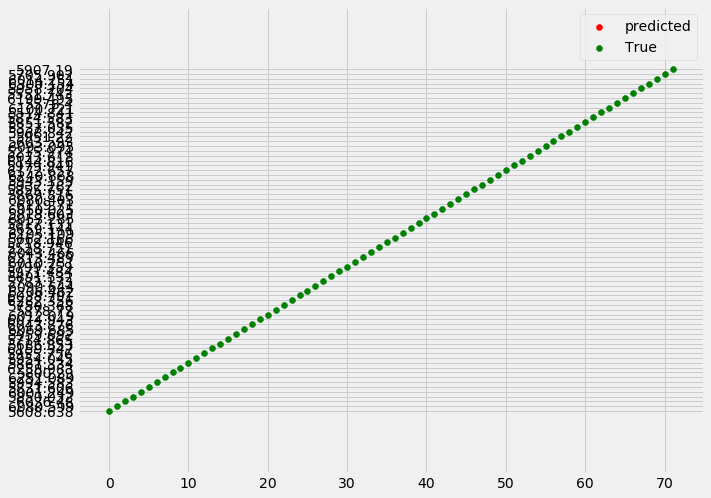

In [119]:
plt.figure(figsize=(10,8))
y_pred=lr.predict(x_test)
plt.scatter(range(y_pred.shape[0]),y_pred,c='r')
plt.scatter(range(y_test.shape[0]),y_test.values,c='g')
plt.legend(['predicted','True'])

In [120]:
#y_pred=lr.predict(x_test)
#y_pred[:100]
#y_test[:100]
#y_pred=lr.predict(x_test)
#y_pred[:100]

# RSI (LR)

In [121]:
x_rsi,y_rsi=split_data(Stock_RSI)
x_rsi.head()

,open,RSI
0,5946.2,50.01119351294685
1,5942.4,50.00821120307454
2,5949.8,50.00644416840592
3,5949.45,50.0065883714907
4,5949.9,50.005130449127336


In [122]:
def Train_test_split(x,y):
  x_train_rsi,x_test_rsi,y_train_rsi,y_test_rsi=train_test_split(x,y,test_size=0.2,random_state=False)
  print(x_train_rsi.shape,x_test_rsi.shape)
  x_train_rsi_scaled=StandardScaler().fit_transform(x_train_rsi)
  #y_train_rsi_scaled=StandardScaler().fit_transform(y_train_rsi.values.reshape(-1,1))
  x_test_rsi_scaled=StandardScaler().fit_transform(x_test_rsi)
  return list(zip(x_train_rsi_scaled,y_train_rsi,x_test_rsi_scaled,y_test_rsi))
  #y_test_rsi_scaled=StandardScaler().fit_transform(y_test_rsi.values.reshape(-1,1))

X_train_rsi,Y_train_rsi,X_test_rsi,Y_test_rsi=zip(*Train_test_split(x_rsi,y_rsi))

(5307, 2) (1327, 2)


In [123]:
Lr=LinearRegression()
Lr.fit(X_train_rsi,Y_train_rsi)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

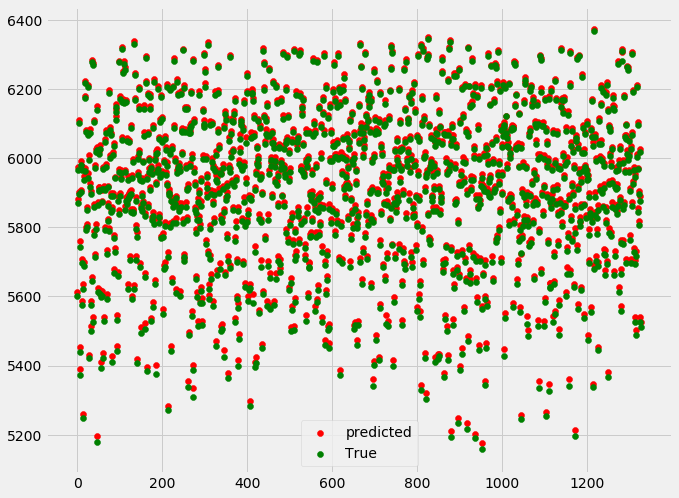

In [124]:
plt.figure(figsize=(10,8))
y_pred=Lr.predict(X_test_rsi)
plt.scatter(range(np.array(Y_test_rsi).shape[0]),y_pred,c='r')
plt.scatter(range(np.array(Y_test_rsi).shape[0]),Y_test_rsi,c='g')
plt.legend(['predicted','True'])

In [125]:
rsi_loss=mean_squared_error(Y_test_rsi,y_pred)
rsi_loss

0.9979209741138199

# OSC (LR)

In [127]:
x_osc,y_osc=split_data(Stock_OSC)
x_osc.head()

,open,OSC
0,5946.2,81.81818181818117
1,5942.4,18.518518518519766
2,5949.8,91.25683060109057
3,5949.45,41.05263157894354
4,5949.9,35.52631578945763


In [128]:
X_train_osc,Y_train_osc,X_test_osc,Y_test_osc=zip(*Train_test_split(x_osc,y_osc))

Lr1=LinearRegression()
Lr1.fit(X_train_osc,Y_train_osc)

(5307, 2) (1327, 2)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

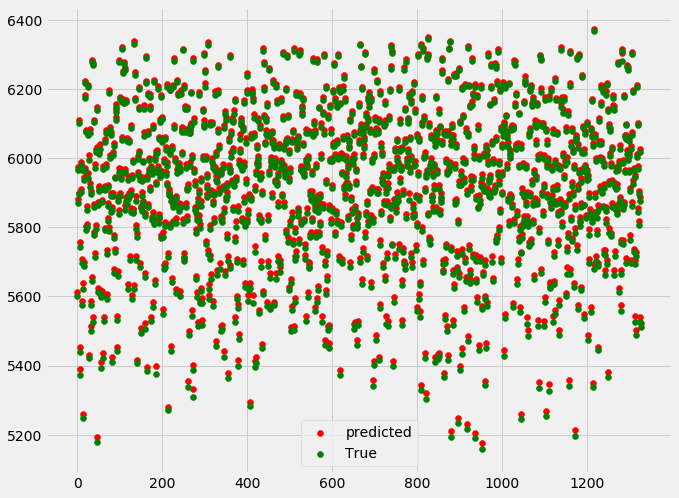

In [129]:
plt.figure(figsize=(10,8))
y_pred1=Lr1.predict(X_test_osc)
plt.scatter(range(np.array(Y_test_osc).shape[0]),y_pred1,c='r')
plt.scatter(range(np.array(Y_test_osc).shape[0]),Y_test_osc,c='g')
plt.legend(['predicted','True'])

In [130]:
osc_loss=r2_score(Y_test_osc,y_pred1)
osc_loss

0.997950898033289

# CCI (LR)

In [132]:
x_cci,y_cci=split_data(Stock_CCI)
x_cci.head()

,high,low,CCI
0,5947.45,5945.8,-74562.94483660047
1,5948.0,5945.6,-190523.86293235794
2,5951.7,5950.1,-164529.6482782842
3,5950.45,5949.25,-407959.1118425084
4,5949.1,5948.45,-515690.1408450541


In [133]:
X_train_cci,Y_train_cci,X_test_cci,Y_test_cci=zip(*Train_test_split(x_cci,y_cci))

Lr2=LinearRegression()
Lr2.fit(X_train_cci,Y_train_cci)

(5306, 3) (1327, 3)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

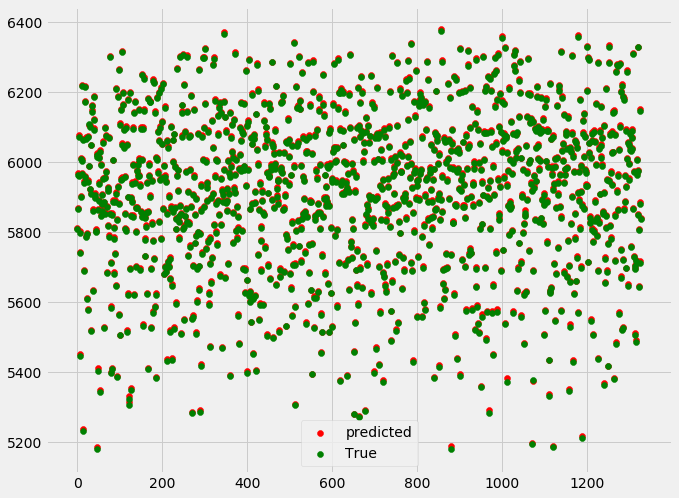

In [134]:
plt.figure(figsize=(10,8))
y_pred2=Lr2.predict(X_test_cci)
plt.scatter(range(np.array(Y_test_cci).shape[0]),y_pred2,c='r')
plt.scatter(range(np.array(Y_test_cci).shape[0]),Y_test_cci,c='g')
plt.legend(['predicted','True'])

In [141]:
cci_loss=r2_score(Y_test_cci,y_pred2)
cci_loss

0.9997010645699791

# RSI and OSC(LR)

In [136]:
data_rsi_osc=pd.concat([Stock_RSI[['date','open','RSI']],Stock_OSC[['OSC','close']]],axis=1)
data_rsi_osc.head()


,date,open,RSI,OSC,close
0,2013-01-01,5946.2,50.01119351294685,81.81818181818117,5945.55
1,2013-01-01,5942.4,50.00821120307454,18.518518518519766,5943.6
2,2013-01-01,5949.8,50.00644416840592,91.25683060109057,5949.9
3,2013-01-01,5949.45,50.0065883714907,41.05263157894354,5949.5
4,2013-01-01,5949.9,50.005130449127336,35.52631578945763,5949.4


In [137]:
x_indc,y_indc=split_data(data_rsi_osc)
x_indc.head()

,open,RSI,OSC
0,5946.2,50.01119351294685,81.81818181818117
1,5942.4,50.00821120307454,18.518518518519766
2,5949.8,50.00644416840592,91.25683060109057
3,5949.45,50.0065883714907,41.05263157894354
4,5949.9,50.005130449127336,35.52631578945763


In [138]:
X_train_indc,Y_train_indc,X_test_indc,Y_test_indc=zip(*Train_test_split(x_indc,y_indc))

Lr3=LinearRegression()
Lr3.fit(X_train_indc,Y_train_indc)

(5307, 3) (1327, 3)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

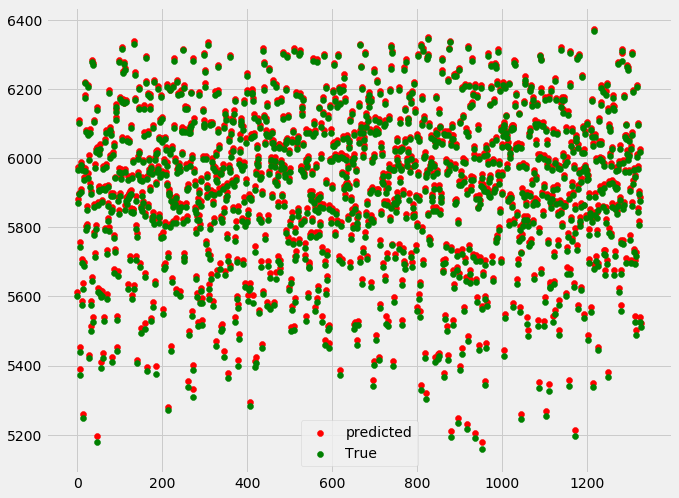

In [139]:
plt.figure(figsize=(10,8))
y_pred4=Lr3.predict(X_test_indc)
plt.scatter(range(np.array(Y_test_indc).shape[0]),y_pred4,c='r')
plt.scatter(range(np.array(Y_test_indc).shape[0]),Y_test_indc,c='g')
plt.legend(['predicted','True'])

In [223]:
indc_loss=mean_squared_error(Y_test_indc,y_pred4)
indc_loss

106.85121690335203

# without tech_indicator(LR)

In [224]:
stock_data['open']=stock_data['open'].apply(lambda x:float(x))
stock_data['high']=stock_data['high'].apply(lambda x:float(x))
stock_data['low']=stock_data['low'].apply(lambda x:float(x))
stock_data['close']=stock_data['close'].apply(lambda x:float(x))

In [225]:
x=stock_data.drop(['date','time','index'],axis=1)
y=stock_data['close']
X_train,Y_train,X_test,Y_test=zip(*Train_test_split(x,y))

(282336, 4) (70584, 4)


In [226]:
Lr4=LinearRegression()
Lr4.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

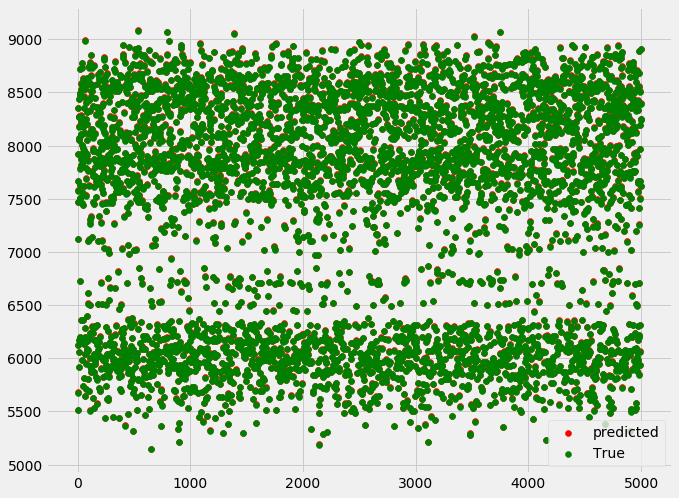

In [227]:
plt.figure(figsize=(10,8))
y_pred3=Lr4.predict(X_test)
plt.scatter(range(5000),y_pred3[:5000],c='r')
plt.scatter(range(5000),Y_test[:5000],c='g')
plt.legend(['predicted','True'])

In [228]:
loss=mean_squared_error(y_pred3,Y_test)
loss

9.021882989519911

# loss comparision

<BarContainer object of 5 artists>

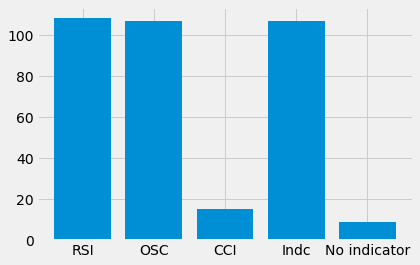

In [229]:
plt.bar(['RSI','OSC','CCI','Indc','No indicator'],[rsi_loss,osc_loss,cci_loss,indc_loss,loss])

# RANDOM FOREST REGRESSOR

In [234]:
rf=RandomForestRegressor(n_estimators=1000,random_state=0)
rf.fit(X_train_osc,Y_train_osc)
y_pred2=rf.predict(X_test_osc)
osc_loss=mean_squared_error(Y_test_osc,y_pred2)
osc_loss

110.75338946256413

# MOVING AVERAGE (RFR)

In [235]:
x=Stock_MAI.drop(['close','date'],axis=1)
y=Stock_MAI['close']

In [236]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(165, 3) (72, 3) (165,) (72,)


In [244]:
rf=RandomForestRegressor(n_estimators=1000,random_state=10)
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [245]:
rf.score(x_test,y_test)
y_pred=rf.predict(x_test)

In [246]:
mai_loss=mean_squared_error(y_test,y_pred)
mai_loss

270.43735876540956

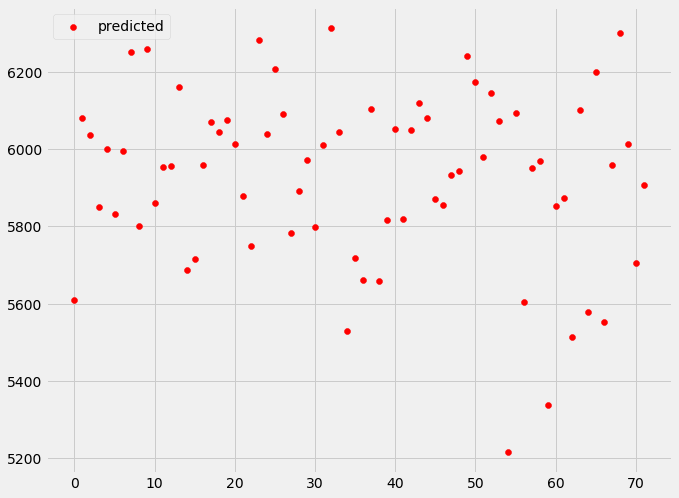

In [251]:
plt.figure(figsize=(10,8))
y_pred=lr.predict(x_test)
plt.scatter(range(y_test.shape[0]),y_pred,c='r')
#plt.scatter(range(y_test.shape[0]),y_test.values,c='g')
plt.legend(['predicted','True'])

In [79]:
#y_pred=lr.predict(x_test)
#y_pred[:100]
#y_test[:100]
#y_pred=lr.predict(x_test)
#y_pred[:100]

# RSI (RFR)

In [80]:
x_rsi,y_rsi=split_data(Stock_RSI)
x_rsi.head()

,open,RSI
0,5946.2,50.01119351294685
1,5942.4,50.00821120307454
2,5949.8,50.00644416840592
3,5949.45,50.0065883714907
4,5949.9,50.005130449127336


In [81]:
def Train_test_split(x,y):
  x_train_rsi,x_test_rsi,y_train_rsi,y_test_rsi=train_test_split(x,y,test_size=0.2,random_state=False)
  print(x_train_rsi.shape,x_test_rsi.shape)
  x_train_rsi_scaled=StandardScaler().fit_transform(x_train_rsi)
  #y_train_rsi_scaled=StandardScaler().fit_transform(y_train_rsi.values.reshape(-1,1))
  x_test_rsi_scaled=StandardScaler().fit_transform(x_test_rsi)
  return list(zip(x_train_rsi_scaled,y_train_rsi,x_test_rsi_scaled,y_test_rsi))
  #y_test_rsi_scaled=StandardScaler().fit_transform(y_test_rsi.values.reshape(-1,1))

X_train_rsi,Y_train_rsi,X_test_rsi,Y_test_rsi=zip(*Train_test_split(x_rsi,y_rsi))

(5307, 2) (1327, 2)


In [82]:
Rf=RandomForestRegressor()
Rf.fit(X_train_rsi,Y_train_rsi)

C:\Users\Ankit Siddhartha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

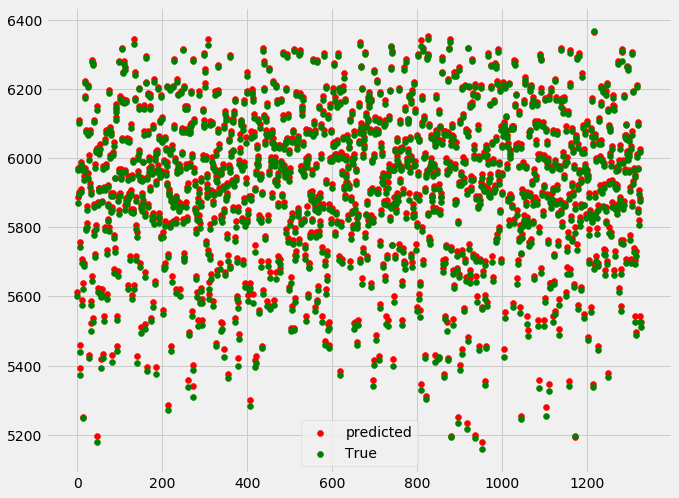

In [83]:
plt.figure(figsize=(10,8))
y_pred=Rf.predict(X_test_rsi)
plt.scatter(cc,y_pred,c='r')
plt.scatter(range(np.array(Y_test_rsi).shape[0]),Y_test_rsi,c='g')
plt.legend(['predicted','True'])

In [84]:
rsi_loss=mean_squared_error(Y_test_rsi,y_pred)
rsi_loss

113.32596006028656

**prediction using OSC**

# OSC (RFR)

In [85]:
x_osc,y_osc=split_data(Stock_OSC)
x_osc.head()

,open,OSC
0,5946.2,81.81818181818117
1,5942.4,18.518518518519766
2,5949.8,91.25683060109057
3,5949.45,41.05263157894354
4,5949.9,35.52631578945763


In [86]:
X_train_osc,Y_train_osc,X_test_osc,Y_test_osc=zip(*Train_test_split(x_osc,y_osc))

Rf1=RandomForestRegressor()
Rf1.fit(X_train_osc,Y_train_osc)

(5307, 2) (1327, 2)


C:\Users\Ankit Siddhartha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

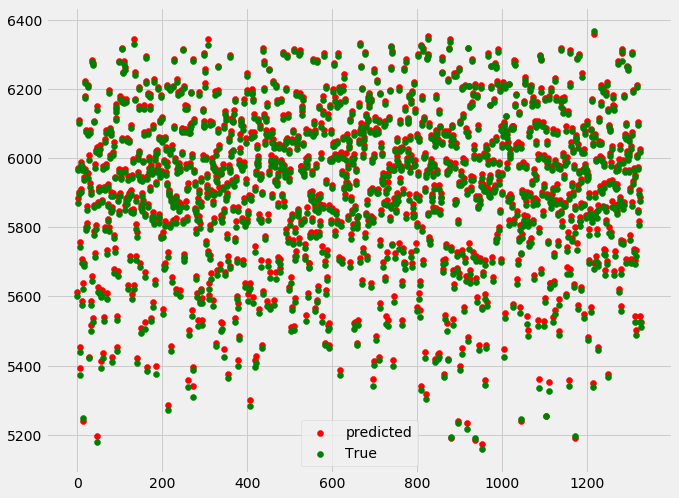

In [87]:
plt.figure(figsize=(10,8))
y_pred1=Rf1.predict(X_test_osc)
plt.scatter(range(np.array(Y_test_osc).shape[0]),y_pred1,c='r')
plt.scatter(range(np.array(Y_test_osc).shape[0]),Y_test_osc,c='g')
plt.legend(['predicted','True'])

In [88]:
osc_loss=mean_squared_error(Y_test_osc,y_pred1)
osc_loss

109.85311761492139

# CCI (RFR)

In [89]:
x_cci,y_cci=split_data(Stock_CCI)
x_cci.head()

,high,low,CCI
0,5947.45,5945.8,-74562.94483660047
1,5948.0,5945.6,-190523.86293235794
2,5951.7,5950.1,-164529.6482782842
3,5950.45,5949.25,-407959.1118425084
4,5949.1,5948.45,-515690.1408450541


In [90]:
X_train_cci,Y_train_cci,X_test_cci,Y_test_cci=zip(*Train_test_split(x_cci,y_cci))

Rf2=RandomForestRegressor()
Rf2.fit(X_train_cci,Y_train_cci)

(5306, 3) (1327, 3)


C:\Users\Ankit Siddhartha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

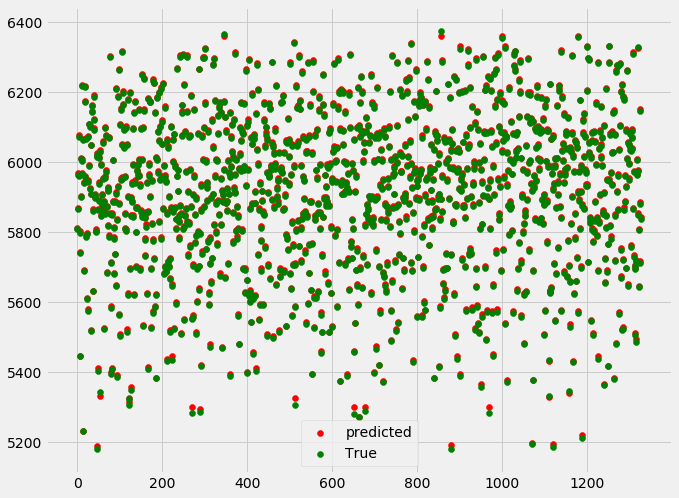

In [91]:
plt.figure(figsize=(10,8))
y_pred2=Rf2.predict(X_test_cci)
plt.scatter(range(np.array(Y_test_cci).shape[0]),y_pred2,c='r')
plt.scatter(range(np.array(Y_test_cci).shape[0]),Y_test_cci,c='g')
plt.legend(['predicted','True'])

In [92]:
cci_loss=mean_squared_error(Y_test_cci,y_pred2)
cci_loss

17.974312735493353

# RSI and OSC(RFR)

In [93]:
data_rsi_osc=pd.concat([Stock_RSI[['date','open','RSI']],Stock_OSC[['OSC','close']]],axis=1)
data_rsi_osc.head()


,date,open,RSI,OSC,close
0,2013-01-01,5946.2,50.01119351294685,81.81818181818117,5945.55
1,2013-01-01,5942.4,50.00821120307454,18.518518518519766,5943.6
2,2013-01-01,5949.8,50.00644416840592,91.25683060109057,5949.9
3,2013-01-01,5949.45,50.0065883714907,41.05263157894354,5949.5
4,2013-01-01,5949.9,50.005130449127336,35.52631578945763,5949.4


In [94]:
x_indc,y_indc=split_data(data_rsi_osc)
x_indc.head()

,open,RSI,OSC
0,5946.2,50.01119351294685,81.81818181818117
1,5942.4,50.00821120307454,18.518518518519766
2,5949.8,50.00644416840592,91.25683060109057
3,5949.45,50.0065883714907,41.05263157894354
4,5949.9,50.005130449127336,35.52631578945763


In [95]:
X_train_indc,Y_train_indc,X_test_indc,Y_test_indc=zip(*Train_test_split(x_indc,y_indc))

Rf3=RandomForestRegressor()
Rf3.fit(X_train_indc,Y_train_indc)

(5307, 3) (1327, 3)


C:\Users\Ankit Siddhartha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

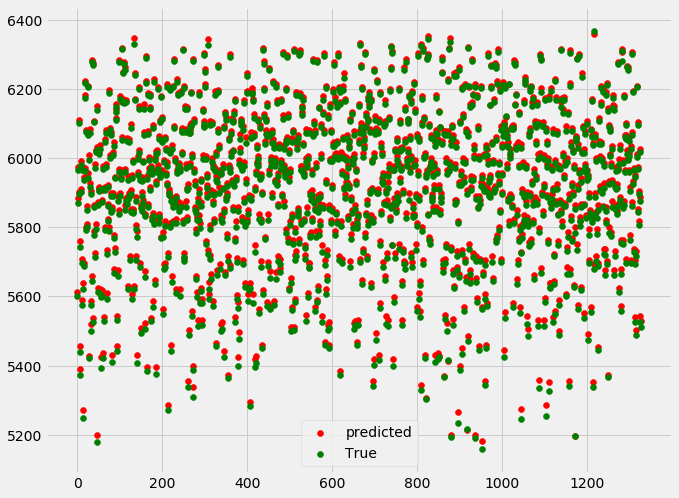

In [96]:
plt.figure(figsize=(10,8))
y_pred4=Rf3.predict(X_test_indc)
plt.scatter(range(np.array(Y_test_indc).shape[0]),y_pred4,c='r')
plt.scatter(range(np.array(Y_test_indc).shape[0]),Y_test_indc,c='g')
plt.legend(['predicted','True'])

In [97]:
indc_loss=mean_squared_error(Y_test_indc,y_pred4)
indc_loss

114.89143760361824

# without tech_indicator(RFR)

In [98]:
stock_data['open']=stock_data['open'].apply(lambda x:float(x))
stock_data['high']=stock_data['high'].apply(lambda x:float(x))
stock_data['low']=stock_data['low'].apply(lambda x:float(x))
stock_data['close']=stock_data['close'].apply(lambda x:float(x))

In [99]:
x=stock_data.drop(['date','time','index'],axis=1)
y=stock_data['close']
X_train,Y_train,X_test,Y_test=zip(*Train_test_split(x,y))

(282336, 4) (70584, 4)


In [100]:
Rf4=RandomForestRegressor()
Rf4.fit(X_train,Y_train)

C:\Users\Ankit Siddhartha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

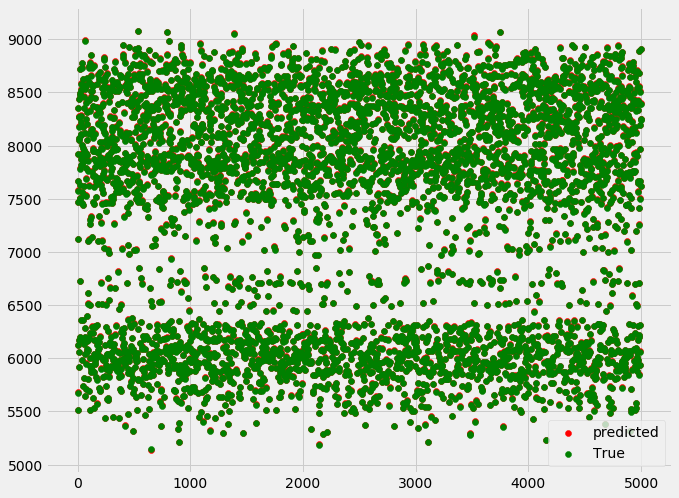

In [101]:
plt.figure(figsize=(10,8))
y_pred3=Rf4.predict(X_test)
plt.scatter(range(5000),y_pred3[:5000],c='r')
plt.scatter(range(5000),Y_test[:5000],c='g')
plt.legend(['predicted','True'])

In [102]:
loss=mean_squared_error(y_pred3,Y_test)
loss

9.064067596055741

# loss comparision

<BarContainer object of 5 artists>

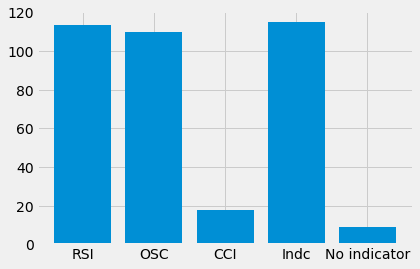

In [103]:
plt.bar(['RSI','OSC','CCI','Indc','No indicator'],[rsi_loss,osc_loss,cci_loss,indc_loss,loss])

# LSTM

In [104]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [135]:
# fix random seed for reproducibility

np.random.seed(7)

# load the dataset

dataframe = pd.read_csv(r'nifty50.csv')
dataset = stock_data['close'].tolist() 
dataset = np.array(dataset)
dataset = np.reshape(dataset , [ len(dataset) ,1] )
dataset
train_size = int(len(dataset) * 0.010)
dataset=dataset[0:train_size,:]
dataset.shape

(3529, 1)

In [136]:
# normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train.shape

(2364, 1)

In [137]:
# reshape into X=t and Y=t+1

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
#trainY.shape
# reshape input to be [samples, time steps, features]


trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)

print(testX.shape)

(2360, 3)
(2360, 1, 3)
(1161, 1, 3)


In [138]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back )))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')



In [139]:
model.fit(trainX, trainY, nb_epoch = 1  , batch_size = 1)

C:\Users\Ankit Siddhartha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/1
2360/2360 [==============================] - 18s 8ms/step - loss: 0.0247


In [140]:
print(trainX.shape)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

(2360, 1, 3)


In [141]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([trainY])
#trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
#testY = scaler.inverse_transform(testY)
print(trainY.shape)
print(testPredict.shape)
print(testY.shape)



(2360,)
(1161, 1)
(1161,)


In [142]:
# calculate root mean squared error

#trainScore = math.sqrt(mean_squared_error(trainY , trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY , testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 5549.42 RMSE


In [153]:
# shift train predictions for plotting

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
trainPredict


array([[5698.0884],
       [5695.568 ],
       [5695.811 ],
       ...,
       [5571.361 ],
       [5571.8877],
       [5570.9854]], dtype=float32)

In [144]:
# shift test predictions for plotting

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


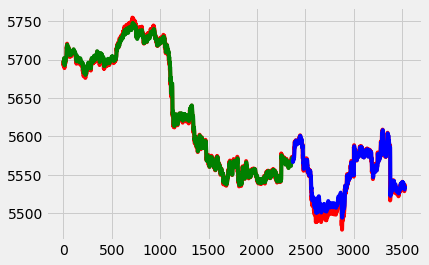

In [145]:
# plot baseline and predictions

plt.plot(scaler.inverse_transform(dataset), color = "r")
plt.plot(trainPredictPlot, color = "g")
plt.plot(testPredictPlot, color = "b" )
plt.show()


In [160]:
#Get the quote
apple_quote=web.DataReader('AAPL',data_source='yahoo',start='2016-01-01',end='2020-04-14')

#Createa new dataframe
new_df=apple_quote.filter(['Close'])

#Get the last 60 day closing price values and conveert the dataframe to array
last_60_days=new_df[-60:].values

#Scale the data to betweeen 0 and 1
last_60_days_scaled=scaler.transform(last_60_days)
#print(last_60_days)
look_back = 3
trainX, trainY = create_dataset(last_60_days, look_back)
#print(trainX)
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
print(trainX.shape)
model.fit(trainX, trainY, nb_epoch = 1  , batch_size = 1)
testPredict=model.predict(trainX)
testPredict = scaler.inverse_transform(testPredict)
testPredict

(56, 1, 3)
Epoch 1/1
45/56 [=======================>......] - ETA: 0s - loss: 82086.939

C:\Users\Ankit Siddhartha\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


56/56 [==============================] - 0s 3ms/step - loss: 81127.1535


array([[6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],
       [6170.2427],


In [161]:
apple_quote2=web.DataReader('AAPL',data_source='yahoo',start='2020-04-14',end='2020-04-15')
print(apple_quote2['Close'])

Date
2020-04-13    273.250000
2020-04-14    287.049988
2020-04-15    284.429993
Name: Close, dtype: float64
